In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable
import time

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [2]:
from problems import Burgers
problem = Burgers()

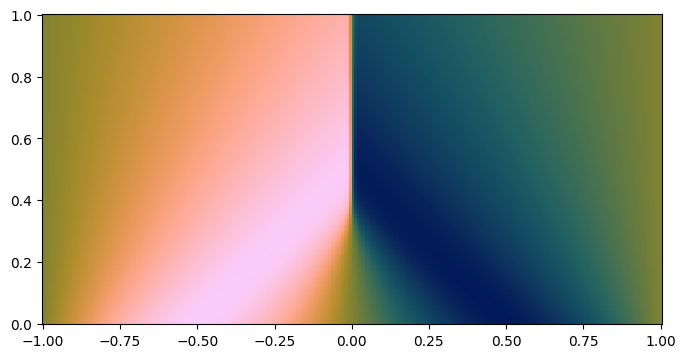

In [3]:
X, T, u_solution = problem.exact_solution(nx=256, nt=256)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax_exact = ax.pcolormesh(X, T, u_solution, cmap=cmap)

In [4]:
class PlateauLM:
    """
    Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        init_lambda=1e-3,
        armijo_constant: float = 1e-4,
        increase_factor: float = 1.25,
        max_trials: int = 100,
    ):
        self.init_lambda = init_lambda
        self.armijo_constant = armijo_constant
        self.increase_factor = increase_factor
        self.max_trials = max_trials

    def init(self, params: eqx.Module):
        """Initializes the optimizer state with the initial damping factor."""
        return {
            'lambda': jnp.asarray(self.init_lambda),
        }

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module, jax.Array], jax.Array],
        collocation_points
    ):
        current_lambda = state['lambda']
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        def vectorized_residual_fn(p):
            return jax.vmap(residual_fn, in_axes=(None, 0))(p, collocation_points)

        residuals = vectorized_residual_fn(params)
        current_loss = jnp.mean(residuals**2)

        def single_row_jacobian_fn(p_flat, xt):
            static = jax.tree_util.tree_map(lambda x: None if isinstance(x, jax.Array) else x, params)
            def residual_for_jac(p_flat_local):
                model = eqx.combine(unflatten(p_flat_local), static)
                return residual_fn(model, xt).sum()
            
            return jax.grad(residual_for_jac)(p_flat)
        
        J = jax.vmap(single_row_jacobian_fn, in_axes=(None, 0))(params_flat, collocation_points)
        Hessian_diag = jnp.sum(J**2, axis=0)
        D_inv = jnp.diag(1.0 / jnp.sqrt(Hessian_diag))
        J_hat = J @ D_inv
        
        U_hat, S_hat, Vt_hat = jnp.linalg.svd(J_hat, full_matrices=False)
        g_hat = U_hat.T @ residuals

        # 1. Generate a range of trial lambdas
        trial_lambdas = current_lambda * (self.increase_factor ** jnp.arange(self.max_trials))

        # 2. Vectorize the trial step evaluation
        def vectorized_evaluate(trial_lambda):
            delta_hat = -Vt_hat.T @ jnp.diag(S_hat / (S_hat**2 + trial_lambda)) @ g_hat
            delta = D_inv @ delta_hat
            
            trial_params = eqx.apply_updates(params, unflatten(delta))
            trial_residuals = vectorized_residual_fn(trial_params)
            trial_loss = jnp.mean(trial_residuals**2)
            
            armijo_satisfied = (trial_loss <= current_loss * 0.99) #- self.armijo_constant * jnp.linalg.norm(delta)**2)
            
            return trial_loss, delta, armijo_satisfied, trial_lambda

        # 3. Vmap this function over the trial lambdas
        losses, deltas, satisfied, lambdas = jax.vmap(vectorized_evaluate)(trial_lambdas)

        # 4. Find the best result using a single selection logic
        # Find the index of the first Armijo-satisfying step. If none exist, returns 0.
        first_satisfied_idx = jnp.argmax(satisfied)

        # Create a boolean mask to select the first satisfied step.
        # This will be all False if no step was satisfied.
        is_satisfied = (jnp.arange(self.max_trials) == first_satisfied_idx)
        
        # If no step satisfied Armijo, we fall back to the step with the minimum loss.
        # This is a safe fallback strategy.
        best_delta_found = jax.lax.cond(
            jnp.any(satisfied),
            lambda: jax.tree_util.tree_map(lambda x: x[first_satisfied_idx], deltas),
            lambda: jax.tree_util.tree_map(lambda x: x[jnp.argmin(losses)], deltas)
        )
        best_loss_found = jax.lax.cond(
            jnp.any(satisfied),
            lambda: losses[first_satisfied_idx],
            lambda: jnp.min(losses)
        )
        best_lambda_found = jax.lax.cond(
            jnp.any(satisfied),
            lambda: lambdas[first_satisfied_idx],
            lambda: lambdas[jnp.argmin(losses)]
        )
        
        updates = unflatten(best_delta_found)
        
        # 5. Update state and metrics
        new_state = {
            'lambda': best_lambda_found * 0.75,
        }
        
        metrics = { 
            'loss': current_loss,
            'singular_values': S_hat,
            'search_direction_norm': jnp.linalg.norm(best_delta_found),
            'lambda': best_lambda_found,
            'trial_count': self.max_trials
        }

        return current_loss, updates, new_state, metrics
    
        
        # current_lambda = state['lambda']
        # params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        # def vectorized_residual_fn(p):
        #     return jax.vmap(residual_fn, in_axes=(None, 0))(p, collocation_points)

        # residuals = vectorized_residual_fn(params)
        # current_loss = jnp.mean(residuals**2)

        # def single_row_jacobian_fn(p_flat, xt):
        #     static = jax.tree_util.tree_map(lambda x: None if isinstance(x, jax.Array) else x, params)
        #     def residual_for_jac(p_flat_local):
        #         model = eqx.combine(unflatten(p_flat_local), static)
        #         return residual_fn(model, xt).sum()
            
        #     return jax.grad(residual_for_jac)(p_flat)
        
        # J = jax.vmap(single_row_jacobian_fn, in_axes=(None, 0))(params_flat, collocation_points)
        # # Hessian_diag = jnp.sum(J**2, axis=0)
        # # D = jnp.diag(jnp.sqrt(Hessian_diag))
        # # J_hat = J @ jnp.linalg.inv(D)
        
        # # U_hat, S_hat, Vt_hat = jnp.linalg.svd(J_hat, full_matrices=False)
        # # g_hat = U_hat.T @ residuals

        # U, S, Vt = jnp.linalg.svd(J, full_matrices=False)
        # g = U.T @ residuals

        # def evaluate_trial_step(loop_val):
        #     _, trial_lambda, previous_trial_loss, _, trial_count = loop_val
        #     delta = -Vt.T @ jnp.diag(S / (S**2 + trial_lambda)) @ g
        #     # delta_hat = -Vt_hat.T @ jnp.diag(S_hat / (S_hat**2 + trial_lambda)) @ g_hat
        #     # delta = jnp.linalg.inv(D) @ delta_hat
            
        #     trial_params = eqx.apply_updates(params, unflatten(delta))
        #     trial_residuals = vectorized_residual_fn(trial_params)
            
        #     trial_loss = jnp.mean(trial_residuals**2)
            
        #     accepted = (trial_loss < current_loss) & (trial_loss > self.plateau_factor * previous_trial_loss)

        #     # If rejected, increase lambda for the next trial
        #     new_lambda = jax.lax.cond(
        #         accepted,
        #         lambda: trial_lambda,
        #         lambda: trial_lambda * self.increase_factor
        #     )
            
        #     return accepted, new_lambda, trial_loss, delta, trial_count + 1

        # def continue_search(loop_val):
        #     # Continue if step not accepted AND we haven't exceeded max trials
        #     accepted, _, trial_loss, _, trial_count = loop_val
        #     return jnp.logical_and(jnp.logical_not(accepted), trial_count < self.max_trials)
        
        # # Run the search loop
        # initial_loop_val = (False, current_lambda, current_loss, jnp.zeros_like(params_flat), 0)
        
        # accepted, final_lambda, new_loss, final_delta, count = jax.lax.while_loop(
        #     continue_search, evaluate_trial_step, initial_loop_val
        # )

        # updates = unflatten(final_delta)
        
        # new_state = {
        #     'lambda': final_lambda * self.decrease_factor,
        # }
        
        # metrics = { 
        #     'loss': current_loss,
        #     'singular_values': S, #S,
        #     'search_direction_norm': jnp.linalg.norm(final_delta),
        #     'lambda': final_lambda,
        #     'trial_count': count
        # }

        # return current_loss, updates, new_state, metrics
    
    
@partial(jax.jit, static_argnums=(3, 4))
def train_step(params, static_parts, opt_state, optimiser, problem, collocation_points, key):
    key, subkey = jax.random.split(key)

    def residual_fn_for_optimizer(p, x):
        rebuilt_model = eqx.combine(p, static_parts)
        # Corrected call without jnp.expand_dims
        return problem.physics_residual(rebuilt_model, x)

    loss, updates, new_opt_state, metrics = optimiser.update(
        params, opt_state, residual_fn_for_optimizer, collocation_points
    )
    new_params = eqx.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss, metrics, key

@partial(jax.jit, static_argnums=(2, 3, 4, 5))
def resample_rad(
    model, candidate_points, n_points_to_sample, problem, k, c, key
):
    # 1. Calculate PDE residuals for all candidate points
    vmapped_residual_fn = jax.vmap(problem.physics_residual, in_axes=(None, 0))
    residuals = vmapped_residual_fn(model, candidate_points)
        
    # 2. Compute sampling probability based on the RAD formula
    epsilon_k = jnp.abs(residuals)**k
    weights = (epsilon_k / jnp.mean(epsilon_k)) + c
    probs = weights / jnp.sum(weights)

    # 3. Sample new points based on the calculated probabilities
    indices = jax.random.choice(
        key,  a=candidate_points.shape[0], shape=(n_points_to_sample,), p=probs, replace=False
    )
    
    return candidate_points[indices]

In [5]:
key = jax.random.PRNGKey(42)

layer_sizes = [2, 20, 20, 20, 20, 1]

model_key, sample_key = jax.random.split(key, 2)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
history = History()

start_time = time.monotonic()

epoch = 0

<function matplotlib.pyplot.show(close=None, block=None)>

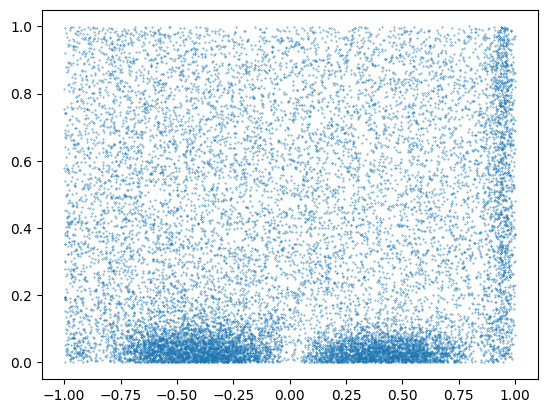

In [6]:
model = eqx.combine(params, static) 

# --- New Hyperparameters for RAD ---
resample_every_n_epochs = 50
rad_k = 1.5
rad_c = 1.0

n_collocation_points = 2**14
n_candidate_points = 20 * n_collocation_points

from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=2, seed=2)
samples = sampler.random(n=n_candidate_points)
l_bounds = [-1, 0]
u_bounds = [1, 1]
scaled_samples = qmc.scale(samples, l_bounds, u_bounds)
candidate_points = jnp.array(scaled_samples)
sample_key, subkey = jax.random.split(sample_key, 2)
collocation_points = resample_rad(
    model, 
    candidate_points, 
    n_collocation_points, 
    problem,
    rad_k,
    rad_c,
    subkey
)
    
plt.scatter(collocation_points[:, 0], collocation_points[:, 1], s=0.1)
plt.show

In [7]:
optimiser = PlateauLM(
    init_lambda=1e2,
    armijo_constant=1e-4,
    increase_factor=1.01,
    max_trials=70,
)
opt_state = optimiser.init(params)

import time

total_train_step_time = 0

In [8]:
for _ in range(400):

    if epoch % resample_every_n_epochs == 0 and epoch > 0:
        sample_key, subkey = jax.random.split(sample_key, 2)
        
        model = eqx.combine(params, static) 
        
        collocation_points = resample_rad(
            model, 
            candidate_points, 
            n_collocation_points, 
            problem,
            rad_k,
            rad_c,
            subkey
        )

    start_train_step_time = time.monotonic()

    params, opt_state, loss_val, metrics, key = train_step(
        params, static, opt_state, optimiser, problem, collocation_points, key
    )
    
    end_train_step_time = time.monotonic()
    total_train_step_time += (end_train_step_time - start_train_step_time)

    if (epoch) % 10 == 0:
        model = eqx.combine(params, static)
        
        u_pred = model.predict(X, T)
        error = np.abs(u_solution - u_pred)
        rel_l2_error = np.linalg.norm(error) / np.linalg.norm(u_solution)
        
        metrics["rell2error"] = rel_l2_error
        
        metrics["time"] = total_train_step_time
        
        history.record(metrics)
        
        if (epoch) % 20 == 0:

            print(f"{rel_l2_error:.3e}", f"{total_train_step_time:.3f}")
            
            print(history.history['trial_count'][-1], history.history['lambda'][-1])

    print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}")

    epoch += 1

model = eqx.combine(params, static)
print("Training complete.")

7.898e-01 10.977
70 100.0
Epoch 1, Loss: 1.687e+01
Epoch 2, Loss: 7.444e+00
Epoch 3, Loss: 5.660e+00
Epoch 4, Loss: 5.568e+00
Epoch 5, Loss: 1.795e+00
Epoch 6, Loss: 1.122e+00
Epoch 7, Loss: 1.108e+00
Epoch 8, Loss: 8.833e-01
Epoch 9, Loss: 7.146e-01
Epoch 10, Loss: 6.947e-01
Epoch 11, Loss: 5.411e-01
Epoch 12, Loss: 4.379e-01
Epoch 13, Loss: 4.118e-01
Epoch 14, Loss: 4.074e-01
Epoch 15, Loss: 4.030e-01
Epoch 16, Loss: 3.457e-01
Epoch 17, Loss: 3.421e-01
Epoch 18, Loss: 3.216e-01
Epoch 19, Loss: 3.182e-01
Epoch 20, Loss: 3.150e-01
3.822e-01 28.526
70 0.9288236
Epoch 21, Loss: 3.099e-01
Epoch 22, Loss: 2.951e-01
Epoch 23, Loss: 2.791e-01
Epoch 24, Loss: 2.635e-01
Epoch 25, Loss: 2.608e-01
Epoch 26, Loss: 2.578e-01
Epoch 27, Loss: 2.416e-01
Epoch 28, Loss: 2.390e-01
Epoch 29, Loss: 2.293e-01
Epoch 30, Loss: 2.269e-01
Epoch 31, Loss: 2.247e-01
Epoch 32, Loss: 2.223e-01
Epoch 33, Loss: 2.199e-01
Epoch 34, Loss: 2.177e-01
Epoch 35, Loss: 2.251e-01
Epoch 36, Loss: 2.227e-01
Epoch 37, Loss: 2

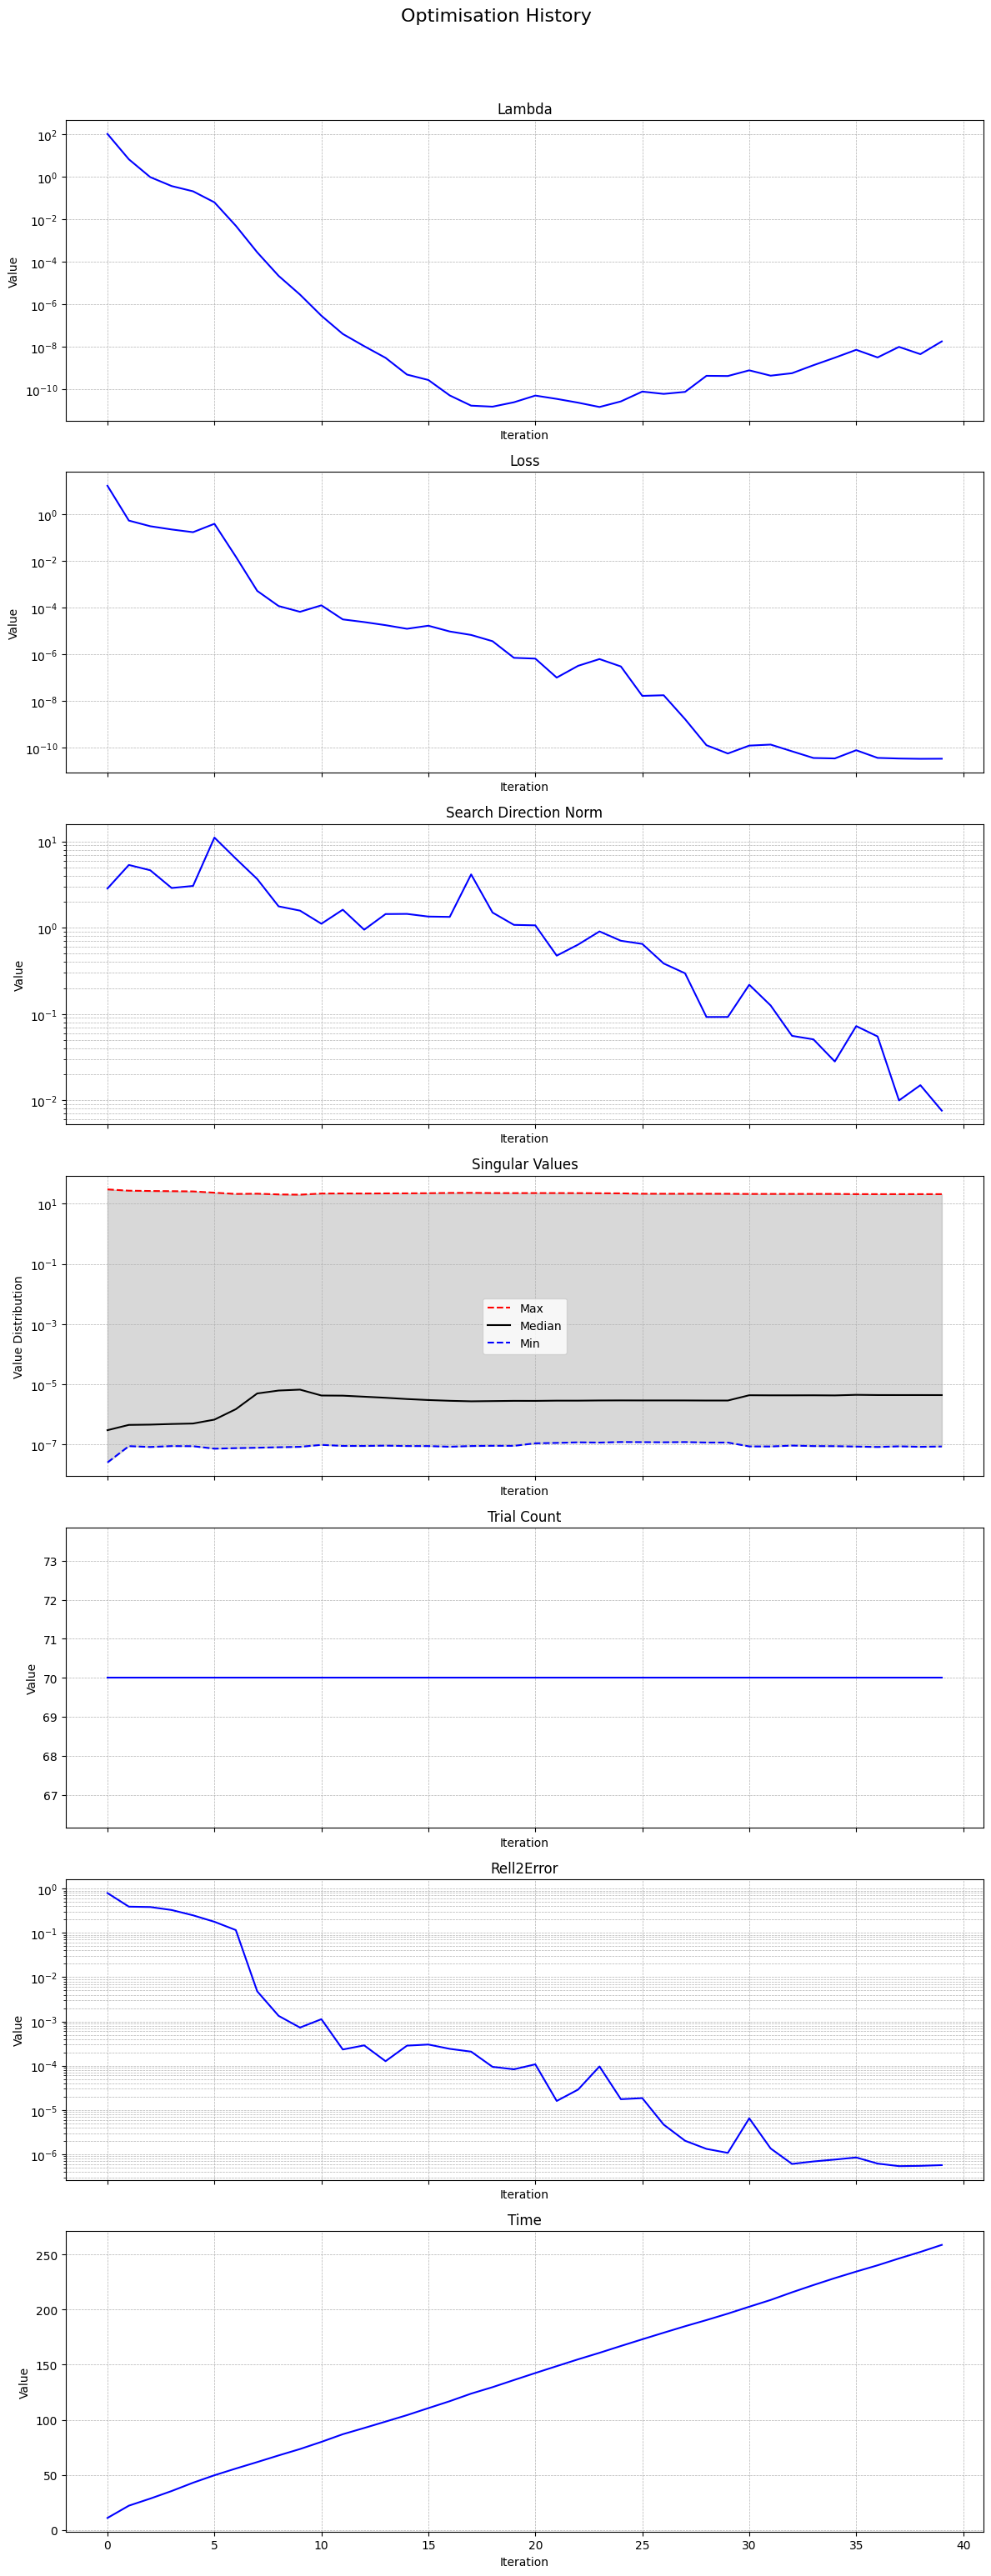

In [9]:
history.plot()

Relative L2 Error: 5.556e-07


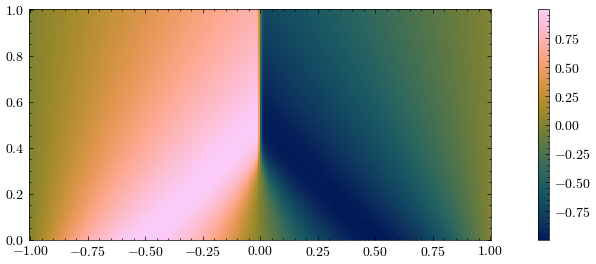

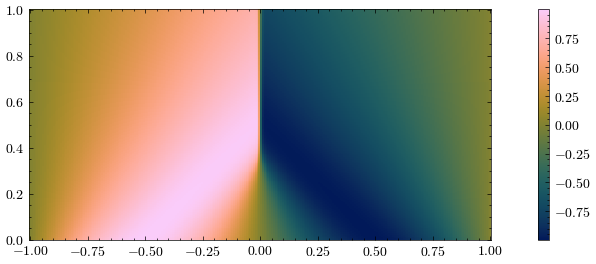

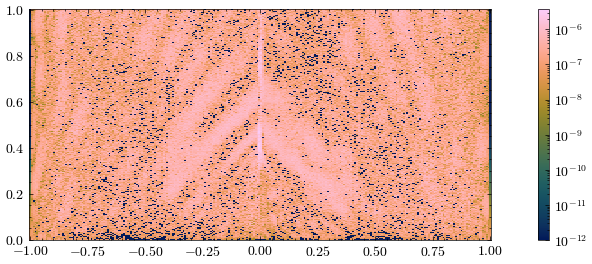

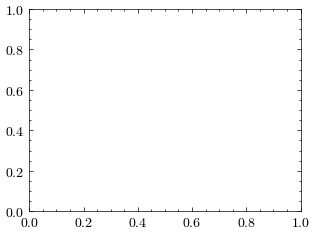

In [17]:
model = eqx.combine(params, static)

u_pred = model.predict(X, T)

error = np.abs(u_solution - u_pred)
rel_l2_error = np.linalg.norm(error) / np.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
ax_sol = ax.pcolormesh(X, T, u_solution, cmap=cmap)
fig.colorbar(ax_sol, ax=ax, pad=0.05)
plt.show()

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
ax_nn = ax.pcolormesh(X, T, u_pred, cmap=cmap)
fig.colorbar(ax_nn, ax=ax, pad=0.05)
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-12, vmax=error.max())
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, T, np.abs(error) + 1e-12, norm=norm, cmap=cmap)
fig.colorbar(nn_error, ax=ax, pad=0.05)
plt.show()

fig, ax = plt.subplots()
plt.show()

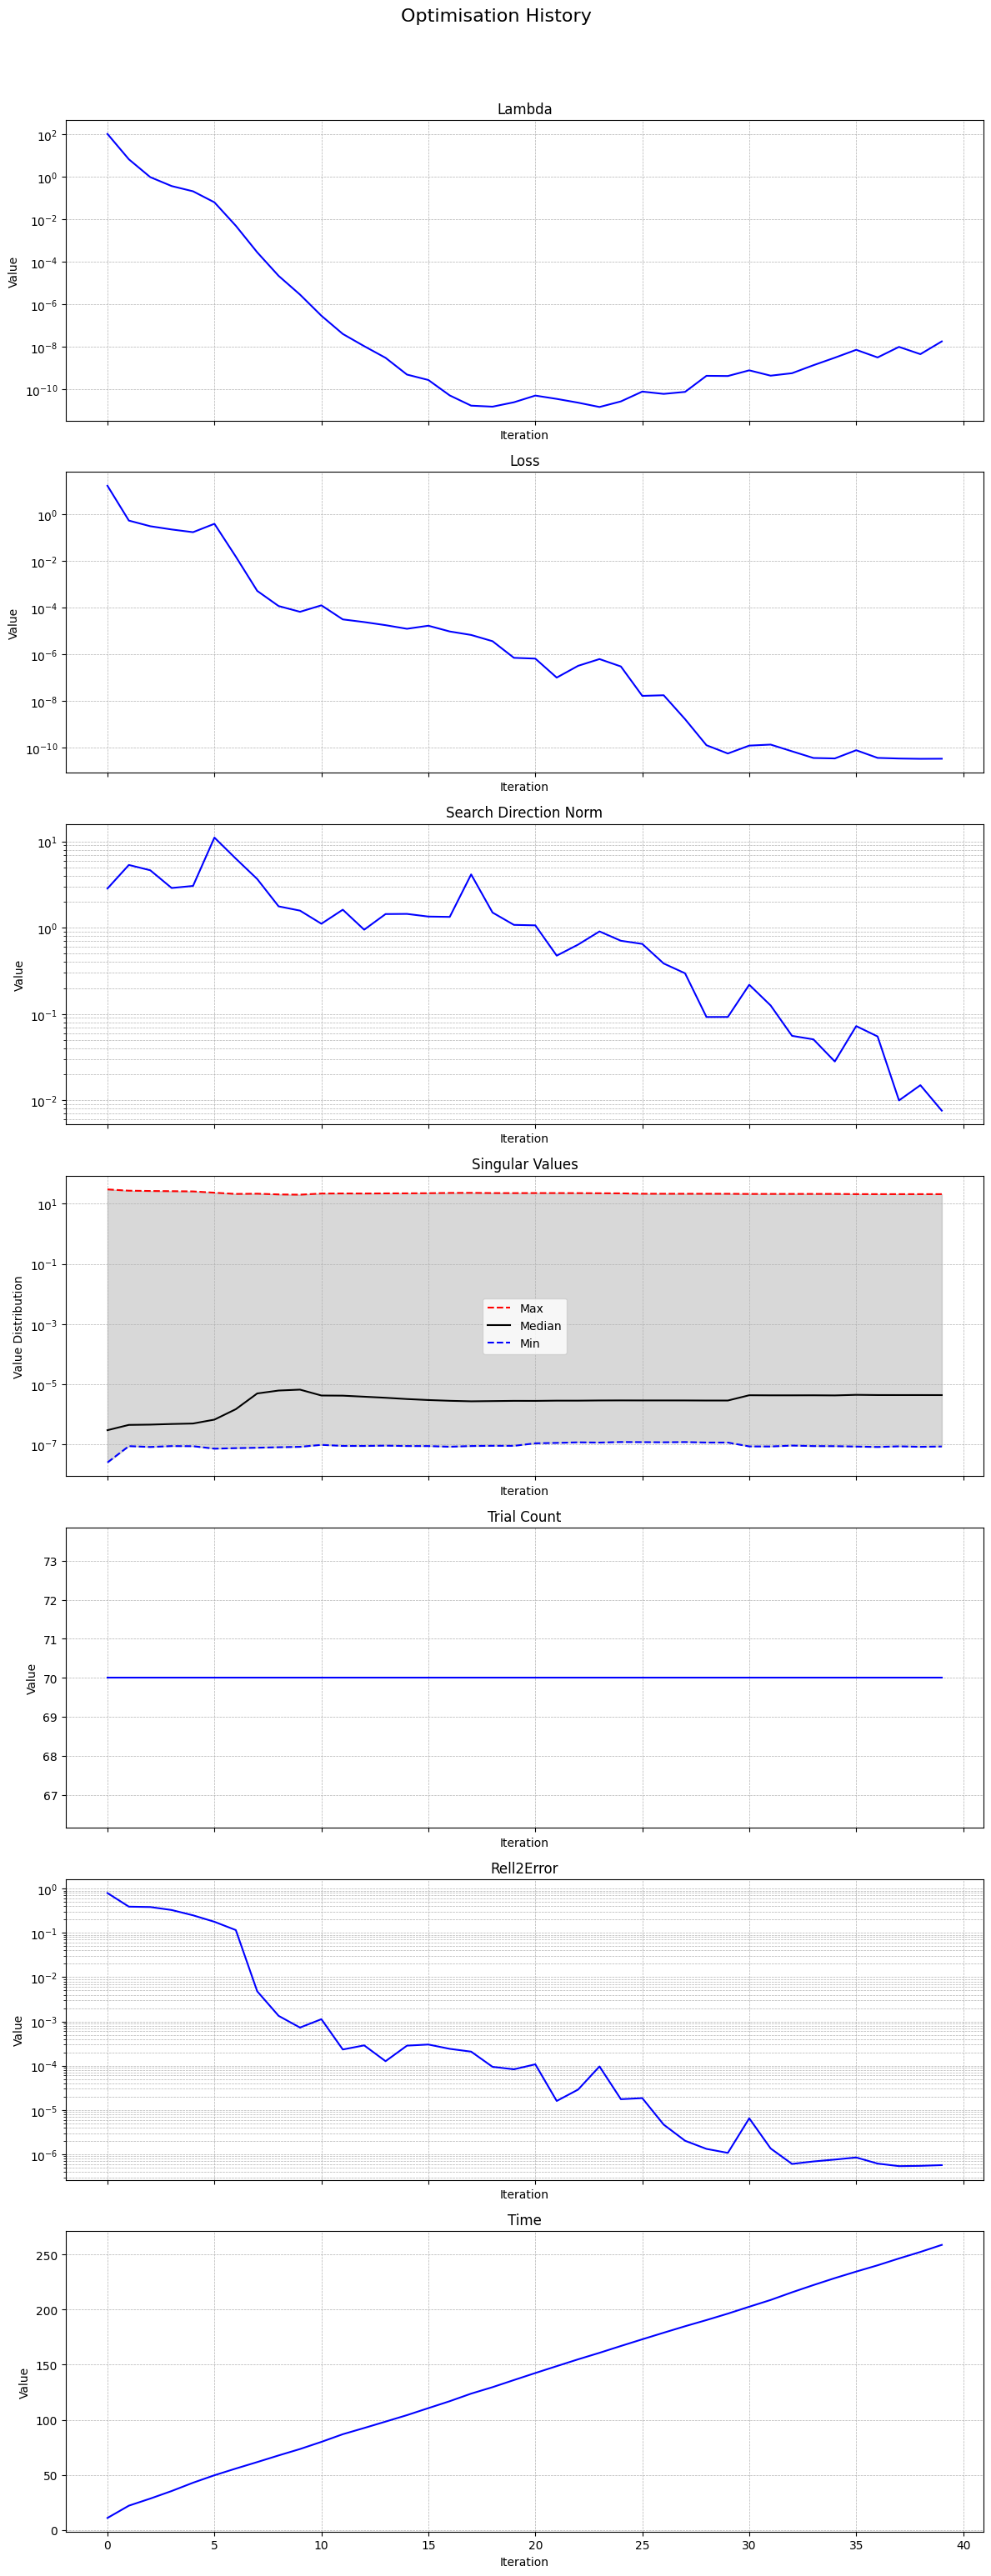

In [11]:
history.plot()

In [12]:
import scienceplots

plt.style.use(['science', 'no-latex'])

In [20]:
burgerslm_l2err = history.history["rell2error"][:400]
burgerslm_loss = history.history["loss"][:400]
burgerslm_lambda = history.history["lambda"][:400]
burgerslm_searchdirnorm = history.history["search_direction_norm"][:400]
burgerslm_svs = history.history["singular_values"][:400]
burgerslm_time = history.history["time"][:400]

np.save('burgerslm_time.npy', burgerslm_time)
np.save('burgerslm_l2err.npy', burgerslm_l2err)
np.save('burgerslm_loss.npy', burgerslm_loss)
np.save('burgerslm_lambda.npy', burgerslm_lambda)
np.save('burgerslm_searchdirnorm.npy', burgerslm_searchdirnorm)
np.save('burgerslm_svs.npy', burgerslm_svs)
np.save('burgerslm_u_pred.npy', u_pred)
np.save('burgerslm_u_solution.npy', u_solution)
np.save('burgerslm_X.npy', X)
np.save('burgerslm_T.npy', T)


In [14]:
print(np.min(burgerslm_l2err))

print(burgerslm_l2err[-1])

5.4094212906862e-07
5.698608805083897e-07


<function matplotlib.pyplot.show(close=None, block=None)>

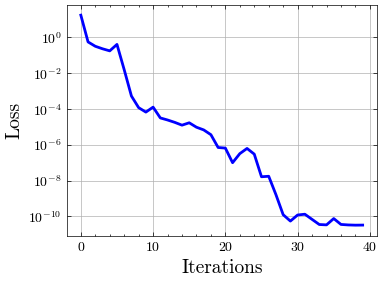

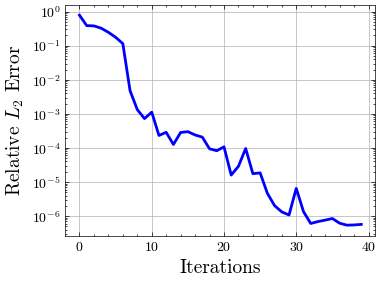

In [15]:
plt.figure(figsize=(4, 3))
plt.plot(burgerslm_loss, color='b', linestyle='-', linewidth=2)
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'Loss', fontsize=14)
plt.grid()
plt.show

plt.figure(figsize=(4, 3))
plt.plot(burgerslm_l2err, color='b', linestyle='-', linewidth=2)
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'Relative $L_2$ Error', fontsize=14)
plt.grid()
plt.show

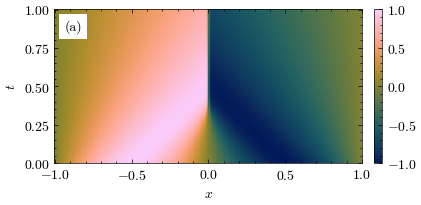

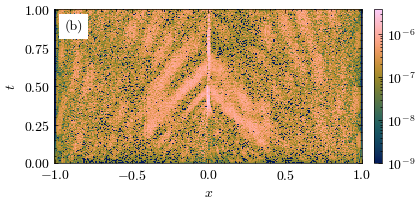

In [16]:
fig, ax = plt.subplots(figsize=(5, 2))
ax.set_aspect("equal")
ax_nn = ax.pcolormesh(X, T, u_pred, cmap=cmap, rasterized=True,
                      vmin=-1,vmax=1)
fig.colorbar(ax_nn, ax=ax, pad=0.03)
ax.annotate("(a)", xy=(0, 1), xycoords='axes fraction',
            xytext=(7, -7), textcoords='offset points',
            ha='left', va='top',
            bbox=dict(facecolor='white', alpha=1.0, linewidth=0))
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
fig.savefig("burgers_lm.pdf", format="pdf")
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-9, vmax=error.max())
fig, ax = plt.subplots(figsize=(5, 2))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, T, np.abs(error) + 1e-9, norm=norm, cmap=cmap, rasterized=True,)
fig.colorbar(nn_error, ax=ax, pad=0.03)
ax.annotate("(b)", xy=(0, 1), xycoords='axes fraction',
            xytext=(7, -7), textcoords='offset points',
            ha='left', va='top',
            bbox=dict(facecolor='white', alpha=1.0, linewidth=0))
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
fig.savefig("burgers_lm_err.pdf", format="pdf")
plt.show()